# Polyserial Correlation

The polyserial correlation is really interesting to consider because it forces you, as a researcher, to consider the nature of your variables. This correlation measures the relationship between one continuous variable and one polychotomous variable. Here's what makes it fun, though: The latent variable underlying the polychotomous variable is not directly observed and assumed to be continuous in nature. Here is an example to make it a bit more concrete:

You are measuring time on task (continuous) for a newly redesigned appointment booking task. Afterwards, you ask your pariticpants to rate their satisfaction with the task on a scale of 1 to 5 where 1 is very unsatisfied, and 5 is very satisfied. The latent variable underlying the satisfaction rating is assumed to be continuous, but we are using the polychotomous rating scale to represent it and stand in for it in the correlation.

At this point it's valid to ask the question: Why would I use polyserial correlation versus something like Spearman correlation? Something like the Spearman correlation is fine if you're doing exploratory work and you aren't assuming your polychotomous variable represents a truly continuous latent variable, or you're not trying to investigate a hypothesis related to your specific variables. However, if in your research you acknowledge one variable is a polychotomized continuous measure, or you form a specific hypothesis like, "I think participants who completed the task quickly will have higher satisfaction," you should use the polyserial correlation.

Just to drive home the complexity of this correlation, unlike other correlations, it does not have a closed-form formula. Instead, you are looking to maximize the log likelihood of your data points for each threshold (polychotomous) value.


__Interpreting the Polyserial Correlation__

Like most of the other correlations, the polyserial correlation is on the range of [-1, 1]. The table below provides guidelines for interpretation, but uses the absolute value of the correlation to set the ranges.

|Correlation Coefficient | Interpretation |
|---------------------------|----------------|
| 0.00 – 0.10 | Negligible or trivial |
| 0.10 – 0.30 | Weak |
| 0.30 – 0.50 | Moderate |
| 0.50 – 1.00 | Strong |


__Assumptions__
1. The continuous variable should be approximately normal.
2. The continuous latent variable underlying the polychotomized variable is approximately normally distributed.
3. The continuous variable and the continuous latent variable can be modeled using a bivariate normal distribution.
  - This means that each variable is normally distributed, and their joint distribution (and linear combination of them) is also normally distributed.
4. The thresholds that polychotomize the latent continuous variable are at fixed regular intervals, and ordered.



## Python Code Example

Once again, I'll generate a small data set with some random values for time on task (seconds) and satisfaction (1 to 5)

In [1]:
# Import
import numpy as np
import pandas as pd

# Correlation coefficient
import scipy.stats as stats

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Seed
np.random.seed(10)

# Create the dataframe
df = pd.DataFrame(data={'time_on_task': list(np.random.normal(60, 15, 100)),
                        'satisfaction': list(np.random.randint(1, 6, 100))})

In [22]:
# Show
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time_on_task  100 non-null    float64
 1   satisfaction  100 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 1.7 KB


In [3]:
# Describe by satisfaction
df.groupby('satisfaction').describe()

time_on_task                                              \
                    count       mean        std        min        25%   
satisfaction                                                            
1                    20.0  60.250345  11.950349  30.682318  54.826496   
2                    20.0  58.502725  13.772995  30.334076  49.322539   
3                    20.0  66.003979  16.235523  38.721660  55.162928   
4                    18.0  58.303124  18.169943  28.024318  50.017554   
5                    22.0  62.478536  12.518060  32.157218  54.023626   

                                               
                    50%        75%        max  
satisfaction                                   
1             61.415526  64.172619  89.776269  
2             58.549540  66.210826  82.268055  
3             63.829606  77.605607  97.014766  
4             57.917236  71.779603  95.774510  
5             64.056000  69.317282  85.089333

In [4]:
# Test normality of time on task
print(stats.shapiro(df['time_on_task']))

ShapiroResult(statistic=np.float64(0.9865036939884573), pvalue=np.float64(0.4051241078138243))


Given the p-value is greater than 0.05, we have to accept the null hypothesis that there is no difference between time on task's distribution and a normal distribution.

Now we can talk about Satisfaction. One easy indicator is the balance of observiations for each rating. They're fairly equal in that one category has 22 observations, three have 20 observations, and one has 18 observations. We can also visualize satisfaction versus time on task using a KDE plot.

<Axes: xlabel='time_on_task', ylabel='satisfaction'>

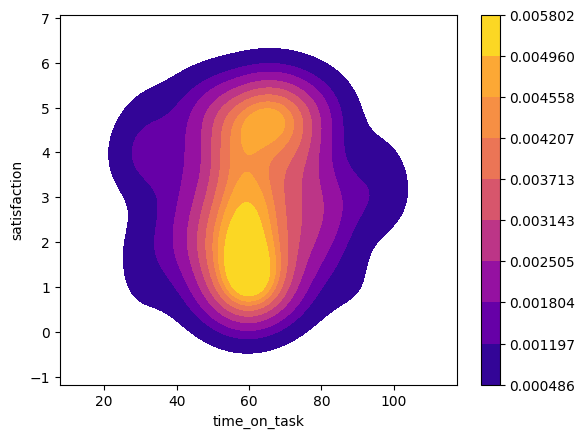

In [5]:
# In case lines are not smooth for contouring, add a jitter
jittered_sat = df['satisfaction'] + np.random.normal(-0.05, 0.05, len(df))
# Build a KDE plot
sns.kdeplot(data=df, x='time_on_task', y=jittered_sat, fill=True, cmap='plasma', cbar=True)

This appears to be unimodal and approximately normally distributed, so we can proceed to calculating the polyserial correlation.

Calculating the polyserial correlation in Python is not easy, though. The best way to do it is actually bridging to R with [rpy2](https://rpy2.github.io/doc/v3.6.x/html/index.html) and then using the polycor library's ```polyserial``` function. (It can also be done in semopy, but that is for structural equation modeling, which is more complicated than what this tutorial is for.)

In [10]:
# Install rpy2 - If you need to do this, uncomment the line below.
#!pip install rpy2

If you're using conda here's the line for installation you will need:
```
conda install conda-forge::rpy2
```

In [42]:
# Necessary imports
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.vectors import IntVector
from rpy2.robjects.packages import importr, isinstalled
from rpy2.robjects import pandas2ri

In [16]:
# Import the needed R libraries
utils = importr('utils')

# Don't go through the install process if don't need to
if not isinstalled('polycor'):
  utils.install_packages('polycor')

# Set the import
polycor = importr('polycor')

(as ‘lib’ is unspecified)







	‘/tmp/RtmpiiqNV6/downloaded_packages’



In [13]:
# Convert the pandas dataframe to an R dataframe by creating a context and using a converter
with (ro.default_converter + pandas2ri.converter).context():
  r_df = ro.conversion.get_conversion().py2rpy(df)

In [40]:
# Convert satisfaction to an ordered factor
r_satisfaction = ro.r['ordered'](r_df.rx2('satisfaction'), levels=IntVector([1, 2, 3, 4, 5]))

# convert to Float Vector
r_time_on_task = r_df.rx2('time_on_task')

In [41]:
# Calculate the polyserial correlation via polyserial()
r_corr = polycor.polyserial(r_time_on_task, r_satisfaction)

# Show
print(f'Polyserial correlation: {r_corr[0]}')

Polyserial correlation: 0.049100187842022726


The polyserial correlation (~0.0491) indicates a very weak positive relationship between time_on_task and satisfaction.

But, is the relationship statistically significant? Let's find out using ```hetcor()``` also from polychor.

In [57]:
# Coerce satisfaction to ordered factor (levels 1-5 assumed)
r_df[r_df.names.index("satisfaction")] = ro.r["ordered"](r_df.rx2("satisfaction"), levels=IntVector([1, 2, 3, 4, 5]))

# Apply hetcor
r_hetcor = polycor.hetcor(r_df, use="complete.obs")

In [56]:
# Show results
print(r_hetcor)


Two-Step Estimates

Correlations/Type of Correlation:
             time_on_task satisfaction
time_on_task            1   Polyserial
satisfaction      0.05048            1

Standard Errors:
[1] ""       "0.1044"

n = 100 

P-values for Tests of Bivariate Normality:
[1] ""       "0.5022"



From the above output, we can see that the correlation is not statistically significant.